# Exploratory Data Analysis (Phase 3)

#### Input: 
   dataset.csv created in stage 2.
#### Output:
   Various parameters required for model training.
#### Algorithm:
   a) Clean dataset.<br>
   b) Finding shape of features created by tfidfVectorizer.<br>
   c) Calculate max sequence length to train doc2vec model.<br>
   d) Compute truncated components for SVD.<br>
   e) Getting insights of data.<br>

Get all the required imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from mpl_toolkits.mplot3d import Axes3D
from  dask_ml.wrappers import Incremental
from dask_ml.cluster import KMeans
from collections import Counter
from dask.distributed import Client
import dask.dataframe as dd
from joblib import parallel_backend
import dask.array as da
import gc
%matplotlib notebook

Import dataset.

In [2]:
client = Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:46241 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.69 GB


In [4]:
df = pd.read_csv("dataset.csv", names=["files", "keywords", "weights"])
df.dropna(inplace=True)

In [5]:
df.head()

,files,keywords,weights
0,User Application for Shop Floor Automation usi...,stable connectivity category data collection e...,165.796429
1,User Application for Shop Floor Automation usi...,predictive tool category development environme...,146.191667
2,User Application for Shop Floor Automation usi...,parameter minimum requirement cpu speed ram...,129.714379
3,User Application for Shop Floor Automation usi...,quirement success success failure success succ...,113.209091
4,User Application for Shop Floor Automation usi...,lled datatype validation unknown user conn...,98.419441


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107843 entries, 0 to 112080
Data columns (total 3 columns):
files       107843 non-null object
keywords    107843 non-null object
weights     107843 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.3+ MB


Clean dataset

In [7]:
blank_indexes = np.array(df.loc[df["keywords"].apply(lambda x: len(x) == 1)].index)

In [8]:
df.drop(labels=blank_indexes, inplace=True)

1) Finding unique files in dataset.

In [9]:
df["files"].nunique()

215

2) Finding no of features in documents.

In [10]:
tf = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), min_df=25, stop_words="english")

In [11]:
tfidf = tf.fit_transform(df["keywords"])

In [12]:
len(tf.get_feature_names())

2246

3) Finding max sequence length

In [13]:
max(df["keywords"].apply(lambda x: len(x.split(" "))))

62

4) Finding which features are mostly describe the file

In [14]:
maxvalues_matrix = tfidf.argmax(axis=0)

In [15]:
feature_max = np.array(maxvalues_matrix.tolist()).reshape(-1)

In [16]:
len(feature_max)

2246

In [17]:
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns=tf.get_feature_names())

In [18]:
tfidf_matrix.head()

,ability,abnormality,abstract,abstractive,ac,accelerate,accelerate evaluate,accelerate evaluate associate,accept,acceptable,...,workstation selection,writer,writing,written,xml,year,yield,youtube,youtube video,zephyr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
tfidf_features = tf.get_feature_names()

In [20]:
feature_tfidf = {}

In [21]:
for i in range(len(tfidf_features)):
    feature_tfidf[tfidf_features[i]] = tfidf_matrix[tfidf_features[i]][feature_max[i]]

In [22]:
feature_tfidf = pd.DataFrame(feature_tfidf, index=[0])

In [23]:
feature_tfidf = pd.DataFrame(feature_tfidf.loc[0]).reset_index()

In [24]:
feature_tfidf.columns = ["words", "idf"]

In [25]:
feature_tfidf.head(5)

,words,idf
0,ability,1.0
1,abnormality,1.0
2,abstract,1.0
3,abstractive,1.0
4,ac,1.0


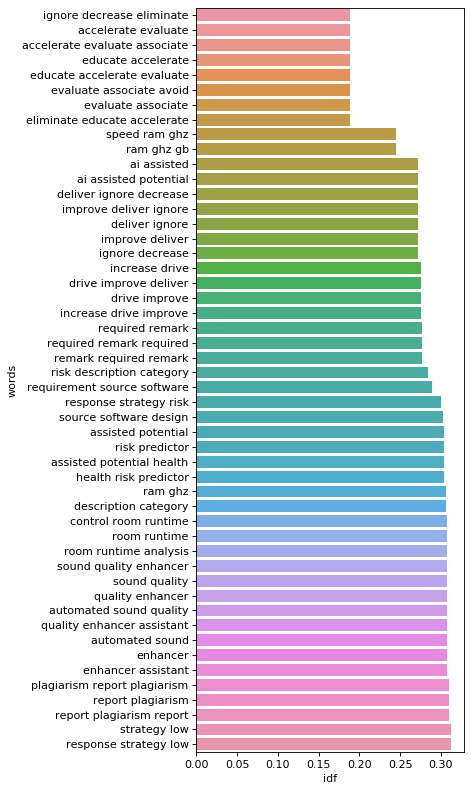

In [26]:
plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
ax = sns.barplot(x="idf", y="words", data=feature_tfidf.sort_values(by="idf")[:50])
plt.tight_layout()
plt.show()

5) Finding higher frequency words in files

In [27]:
keywords_df = df.groupby("files").agg({"keywords": lambda x: " ".join(x.tolist()).split(" ")}).reset_index()

In [28]:
keywords_df.head(5)

,files,keywords
0,2D TO 3D IMAGE CONVERSION USING_MACHINE LEARNI...,"[nvidia, gtx, , gb, graphic, card, software, d..."
1,3D-image terrain classification using machine ...,"[parameter, minimum, requirement, justication,..."
2,A CRYPTOSYSTEM FOR ENCRYPTION OF_DATA USING IM...,"[october, , , , , , , , , , , , , , , , , tabl..."
3,A NALYSIS OF G ENE R EGULATION USING_D EEP L E...,"[, , , , , , , , , , task, literature, survey,..."
4,A SYSTEM FOR LANGUAGE TRANSLATION.pdf,"[risk, description, project, scope, stability,..."


In [29]:
def plot_higher_frequency_words(index):
    sorted_dict = dict(sorted(dict(Counter(keywords_df["keywords"][index])).items(), key=lambda x: x[1], reverse=True))
    if "" in sorted_dict:
        del sorted_dict[""]
    sorted_dict = pd.DataFrame(sorted_dict, index=[0])
    sorted_dict = pd.DataFrame(sorted_dict.loc[0]).reset_index()
    sorted_dict.columns = ["words", "frequency"]
    plt.figure(num=None, figsize=(6, 10), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.barplot(x="frequency", y="words", data=sorted_dict[:50])
    plt.tight_layout()
    plt.show()

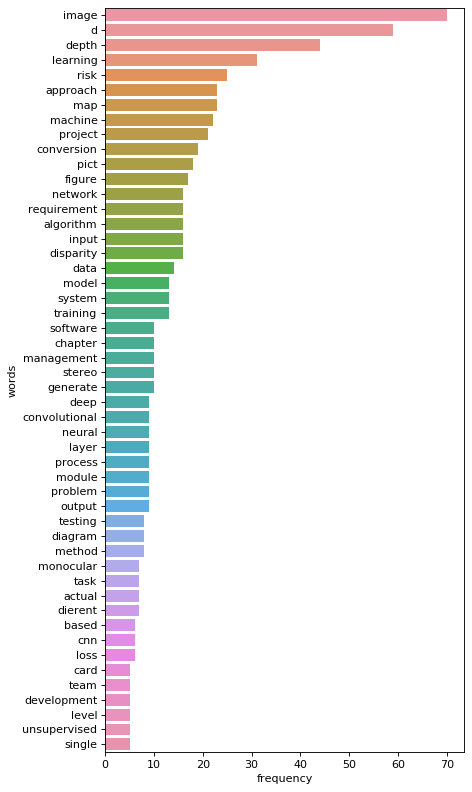

CPU times: user 654 ms, sys: 35.9 ms, total: 690 ms
Wall time: 653 ms


In [30]:
%%time
plot_higher_frequency_words(0)

In [31]:
pca = PCA(n_components=3)

In [32]:
def visualize_pca(matrix):
    pca_transformed = pca.fit_transform(matrix)
    pca_transformed = pd.DataFrame(pca_transformed, columns=["col1", "col2", "col3"])
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    xs = pca_transformed["col1"]
    ys = pca_transformed["col2"]
    zs = pca_transformed["col3"]
    ax.scatter(xs, ys, zs, s=[50, 100, 200], c=zs, alpha=0.6, edgecolors='w')

    ax.set_xlabel('col1')
    ax.set_ylabel('col2')
    ax.set_zlabel('col3')
    return pca_transformed

6) Finding components for SVD

In [33]:
svd = TruncatedSVD(n_components=tfidf.shape[1]-1)

In [34]:
%%time
svd.fit(tfidf_matrix)

CPU times: user 9min 49s, sys: 19.6 s, total: 10min 9s
Wall time: 3min 13s


TruncatedSVD(algorithm='randomized', n_components=2245, n_iter=5,
             random_state=None, tol=0.0)

In [35]:
svd.explained_variance_ratio_

array([1.17967646e-02, 9.32510088e-03, 8.87235289e-03, ...,
       4.23696174e-36, 1.49014418e-37, 1.17042703e-37])

Text(0, 0.5, 'cumulative explained variance')

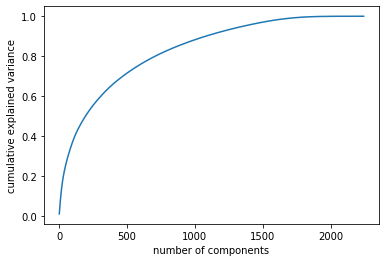

In [36]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [37]:
def select_n_components(variance_ratio, goal_variance):
    total_variance = 0.0
    n_components = 0
    
    for var in variance_ratio:
        total_variance += var
        n_components += 1
        
        if total_variance >= goal_variance:
            break
    
    return n_components

In [38]:
select_n_components(svd.explained_variance_ratio_, 0.95)

1356

In [39]:
%%time
tagged_data = [TaggedDocument(words=word_tokenize("".join(_d)), tags=[i]) for i, _d in enumerate(df["keywords"])]
doc2vec = Doc2Vec(vector_size=62, hs=1, sample=0,  min_count=25, epochs=10, seed=0, window=3, dm=1)
doc2vec.build_vocab(tagged_data)
doc2vec.train(tagged_data, total_examples=doc2vec.corpus_count, epochs=10)

CPU times: user 41.7 s, sys: 7.96 s, total: 49.6 s
Wall time: 37.4 s


In [40]:
%matplotlib notebook

<IPython.core.display.Javascript object>


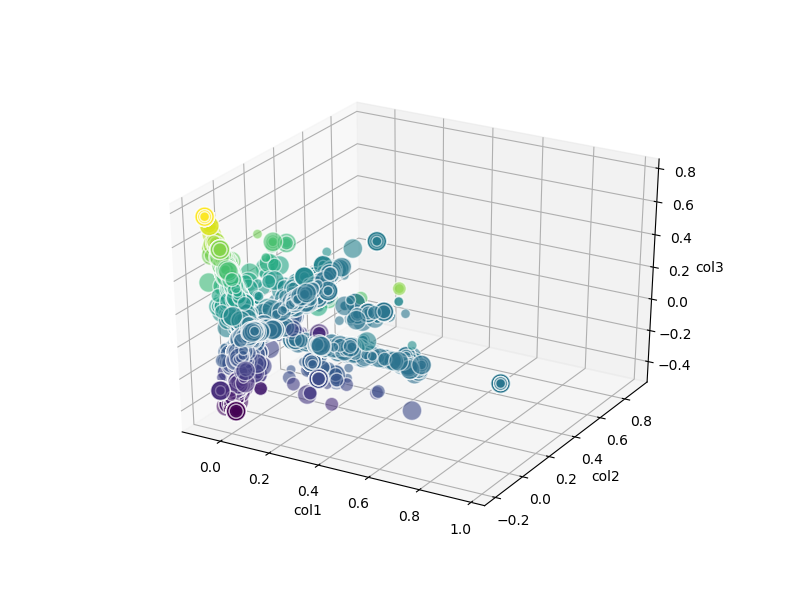

CPU times: user 11.7 s, sys: 1.33 s, total: 13 s
Wall time: 4.7 s


In [41]:
%%time
tfidf_pca = visualize_pca(tfidf_matrix)

<IPython.core.display.Javascript object>


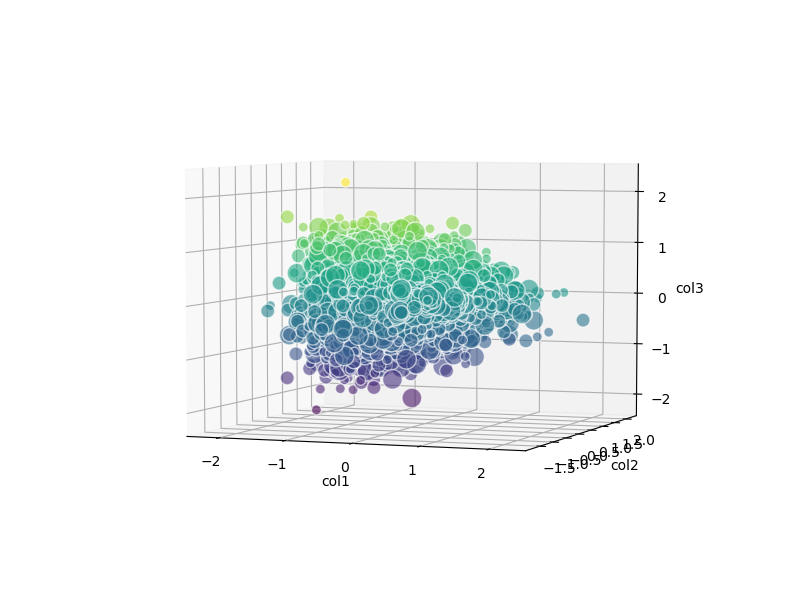

CPU times: user 1.21 s, sys: 43.1 ms, total: 1.25 s
Wall time: 415 ms


In [42]:
%%time
doc2vec_pca=visualize_pca(doc2vec.docvecs.vectors_docs)

In [43]:
inertia_ = []

In [44]:
doc2vec_matrix = pd.DataFrame(doc2vec.docvecs.vectors_docs)

In [45]:
doc2vec_matrix = dd.from_pandas(doc2vec_matrix, npartitions=100)

In [46]:
client.scheduler_info()

{'type': 'Scheduler',
 'id': 'Scheduler-2ebb1ece-68c3-4104-a3d8-d2e8ef2da1ad',
 'address': 'tcp://127.0.0.1:46241',
 'services': {'dashboard': 8787},
 'workers': {'tcp://127.0.0.1:33819': {'type': 'Worker',
   'id': 3,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/home/dhiraj/Recommendation/dask-worker-space/worker-k2mkp3jh',
   'name': 3,
   'nthreads': 1,
   'memory_limit': 4173260800,
   'last_seen': 1570201203.9788413,
   'services': {},
   'metrics': {'cpu': 4.0,
    'memory': 41435136,
    'time': 1570201203.97497,
    'read_bytes': 13464.004130919551,
    'write_bytes': 13464.004130919551,
    'num_fds': 22,
    'executing': 0,
    'in_memory': 0,
    'ready': 0,
    'in_flight': 0,
    'bandwidth': 100000000},
   'nanny': 'tcp://127.0.0.1:36149'},
  'tcp://127.0.0.1:42361': {'type': 'Worker',
   'id': 0,
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': '/home/dhiraj/Recommendation/dask-worker-space/worker-x5ilf_sn',
   'name': 0,
   'nthre

In [47]:
doc2vec_persist = client.persist(doc2vec_matrix)

In [48]:
%%time
for i in range(2, 11):
    cluster = KMeans(n_clusters=i, random_state=89)
    cluster.fit(doc2vec_persist)
    inertia_.append(cluster.inertia_)
    print("Inertia: {}".format(cluster.inertia_))

Inertia: 88556.39965651487
Inertia: 86426.89794006158
Inertia: 84056.50634364304
Inertia: 83102.57976129353
Inertia: 81820.60603154967
Inertia: 81032.20867489504
Inertia: 79672.02576828541
Inertia: 79011.3047999346
Inertia: 79068.68749542552
CPU times: user 5min 44s, sys: 20.1 s, total: 6min 4s
Wall time: 11min 12s


<IPython.core.display.Javascript object>


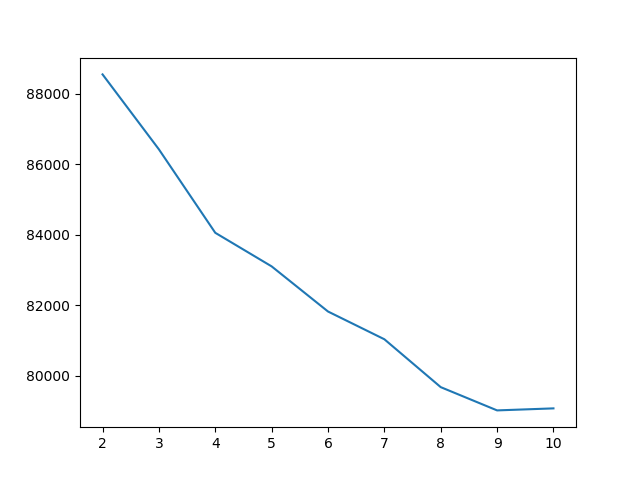

In [49]:
plt.plot(range(2, 11), inertia_)

In [51]:
df.to_csv("dataset_processed.csv", index=False)

# Observations

1) Total files: 215<br>
2) Features trained by tfidf vectorizer: 2246<br>
3) Max sequence length: 62<br>
4) Features idf are: trigrams < bigrams < unigrams<br>
5) Components for truncated SVD: 1356<br>
6) Clusters for doc2vec: 4

# End of Phase 3